## <u>*Classsification Modelling for gender as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json

In [2]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

---

*Importing Data :*

In [3]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


---

*Sorting Data :*

In [4]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


---

*Data Shape :*

In [5]:
df.shape

(67856, 8)

---

*Define categorical features and numerical features :*

In [6]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


---

*Categorical features Frequency percenatge :*

In [7]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    32.764973
HBACK    27.875206
STNWG    23.963983
UTE       6.758430
TRUCK     2.578991
HDTOP     2.326987
COUPE     1.149493
PANVN     1.108229
MIBUS     1.056649
MCARA     0.187161
CONVT     0.119370
BUS       0.070738
RDSTR     0.039790
Name: proportion, dtype: float64
veh_age
3    29.568498
4    27.923839
2    24.444412
1    18.063252
Name: proportion, dtype: float64
gender
F    56.88959
M    43.11041
Name: proportion, dtype: float64
area
C    30.269983
A    24.039142
B    19.660752
D    12.044624
E     8.712568
F     5.272931
Name: proportion, dtype: float64
agecat
4    23.857876
3    23.235970
2    18.974004
5    15.821740
6     9.648373
1     8.462037
Name: proportion, dtype: float64


---

*Visualizing numerical features :*

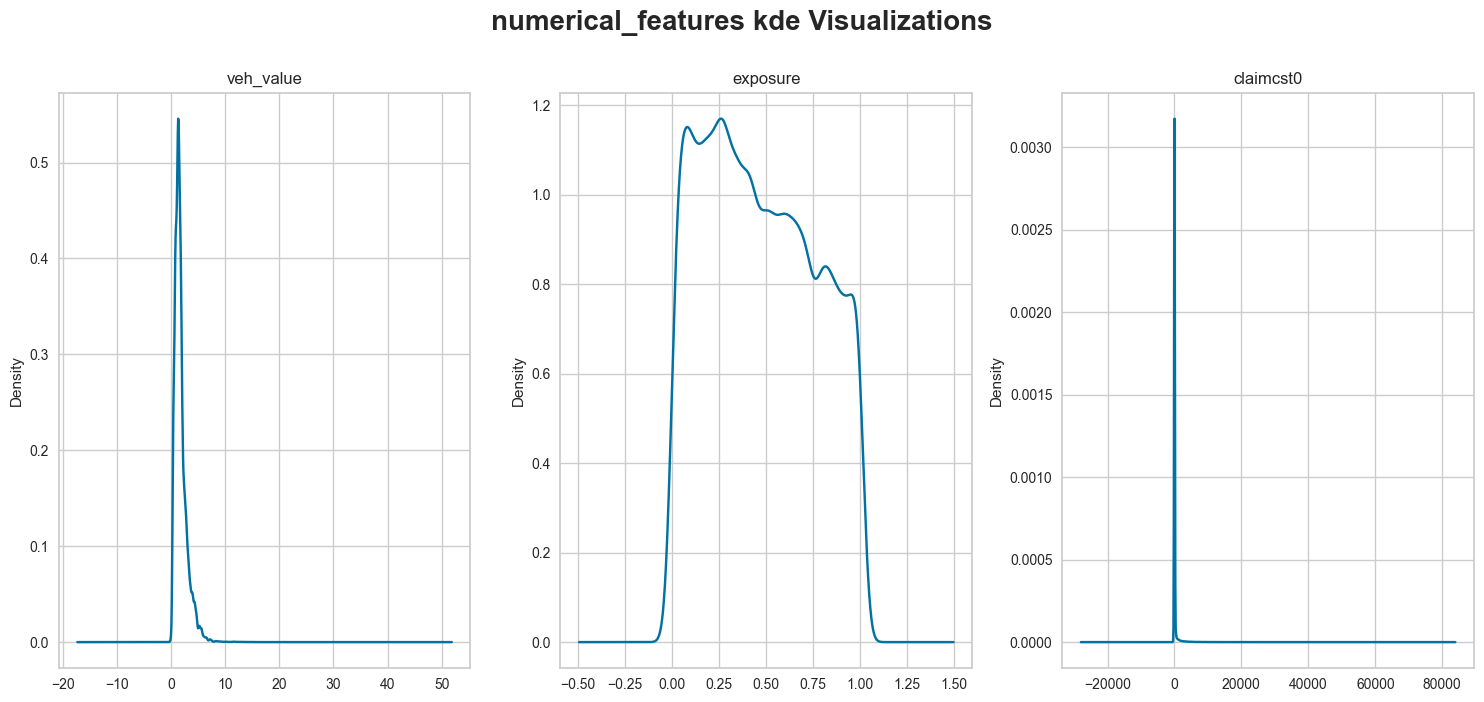

In [31]:
def plot_numerical_features(numerical_features,ChartType):
    
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}",title=column)
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features.png',dpi=500);
        


    plt.tight_layout()
    plt.show();

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde");


---

*Visualizing categorical features :*

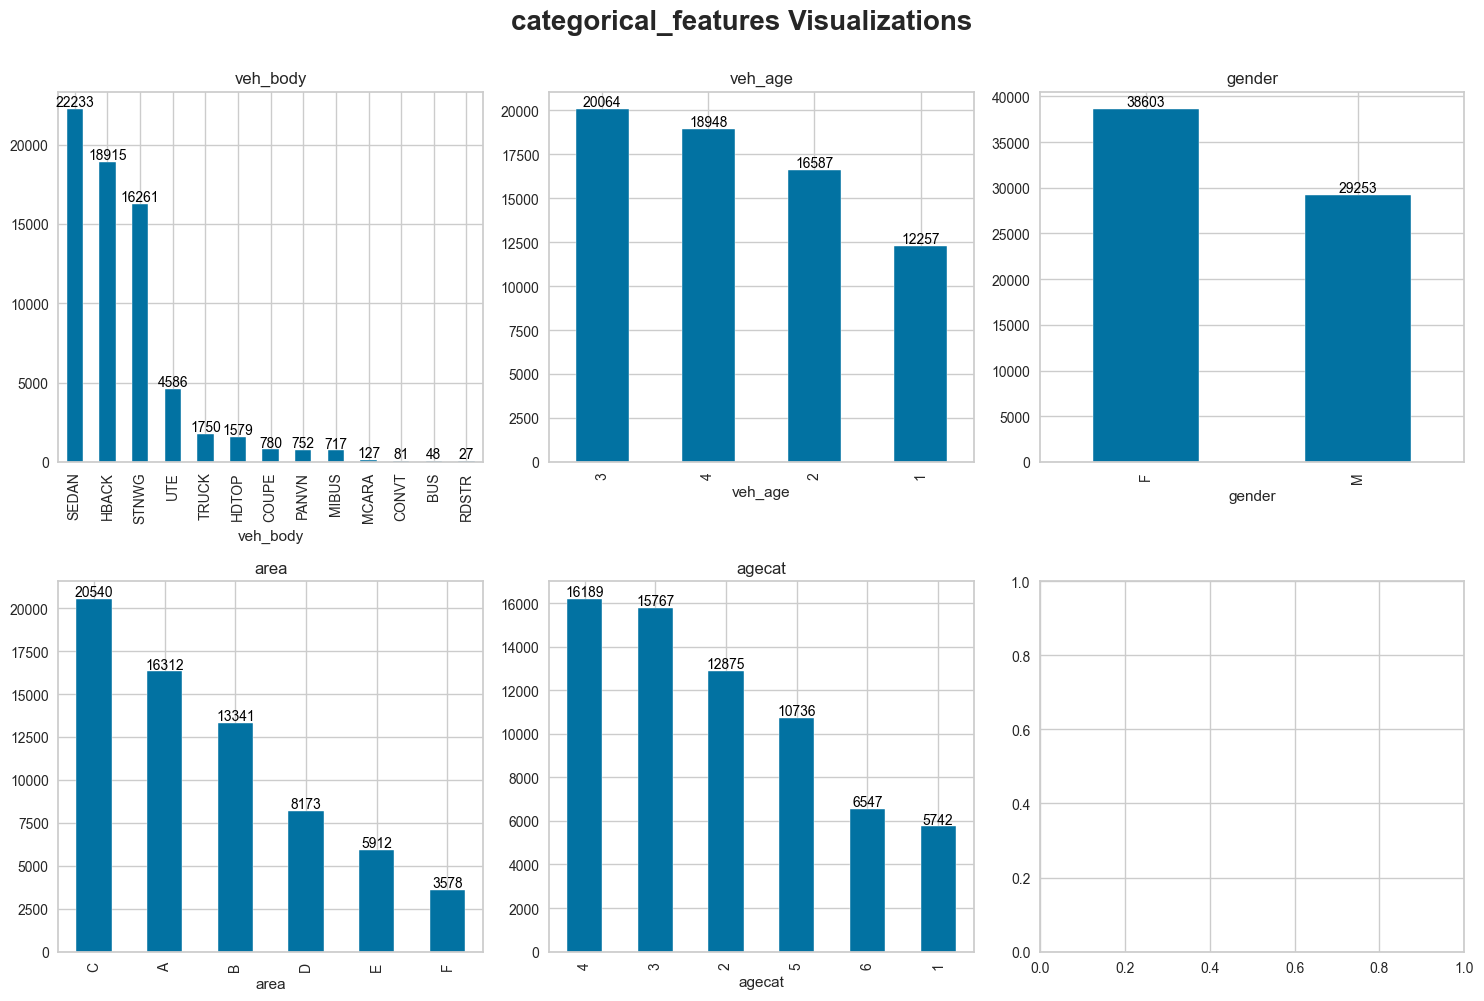

In [21]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [22]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [23]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features Frequency percenatge by gender :*

In [24]:
df.groupby("area")["gender"].value_counts(normalize=True).to_frame()*100

proportion
area gender            
A    F        56.921285
     M        43.078715
B    F        57.274567
     M        42.725433
C    F        57.512171
     M        42.487829
D    F        57.959134
     M        42.040866
E    F        55.328146
     M        44.671854
F    F        51.872554
     M        48.127446

* *Insights :*

*1. Females Proportions are more than males in all areas*

*2. Area F has the lowest Proportion variance between genders*

---

In [26]:
df.groupby("agecat")["gender"].value_counts(normalize=True).to_frame()*100

proportion
agecat gender            
1      F        57.018460
       M        42.981540
2      F        59.122330
       M        40.877670
3      F        59.104459
       M        40.895541
4      F        57.928223
       M        42.071777
5      F        53.735097
       M        46.264903
6      M        50.343669
       F        49.656331

* *Insights :*

*1. Females Proportions are more than males among all age categories except for age category 6*

*2. In age category 6 where the Proportion of males more than females the Proportion variance is the lowest between genders*

---

In [27]:
df.groupby("veh_age")["gender"].value_counts(normalize=True).to_frame()*100

proportion
veh_age gender            
1       F        58.293220
        M        41.706780
2       F        59.896304
        M        40.103696
3       F        58.348285
        M        41.651715
4       F        51.804940
        M        48.195060

* *Insights :*

*1. Females Proportions are more than males among all veh ages*

*2. veh age 4 has the lowest Proportion variance between genders*

In [28]:
df.groupby("veh_body")["gender"].value_counts(normalize=True).to_frame()*100

proportion
veh_body gender            
BUS      M        66.666667
         F        33.333333
CONVT    F        62.962963
         M        37.037037
COUPE    F        53.205128
         M        46.794872
HBACK    F        70.483743
         M        29.516257
HDTOP    M        54.971501
         F        45.028499
MCARA    M        59.842520
         F        40.157480
MIBUS    F        58.437936
         M        41.562064
PANVN    M        77.260638
         F        22.739362
RDSTR    M        70.370370
         F        29.629630
SEDAN    F        61.732560
         M        38.267440
STNWG    M        50.654941
         F        49.345059
TRUCK    M        77.371429
         F        22.628571
UTE      M        72.001744
         F        27.998256

* *Insights :*

*1. The Proportions are vary among all veh_body*

---

*Visualizing Categorical and numerical features by gender :*

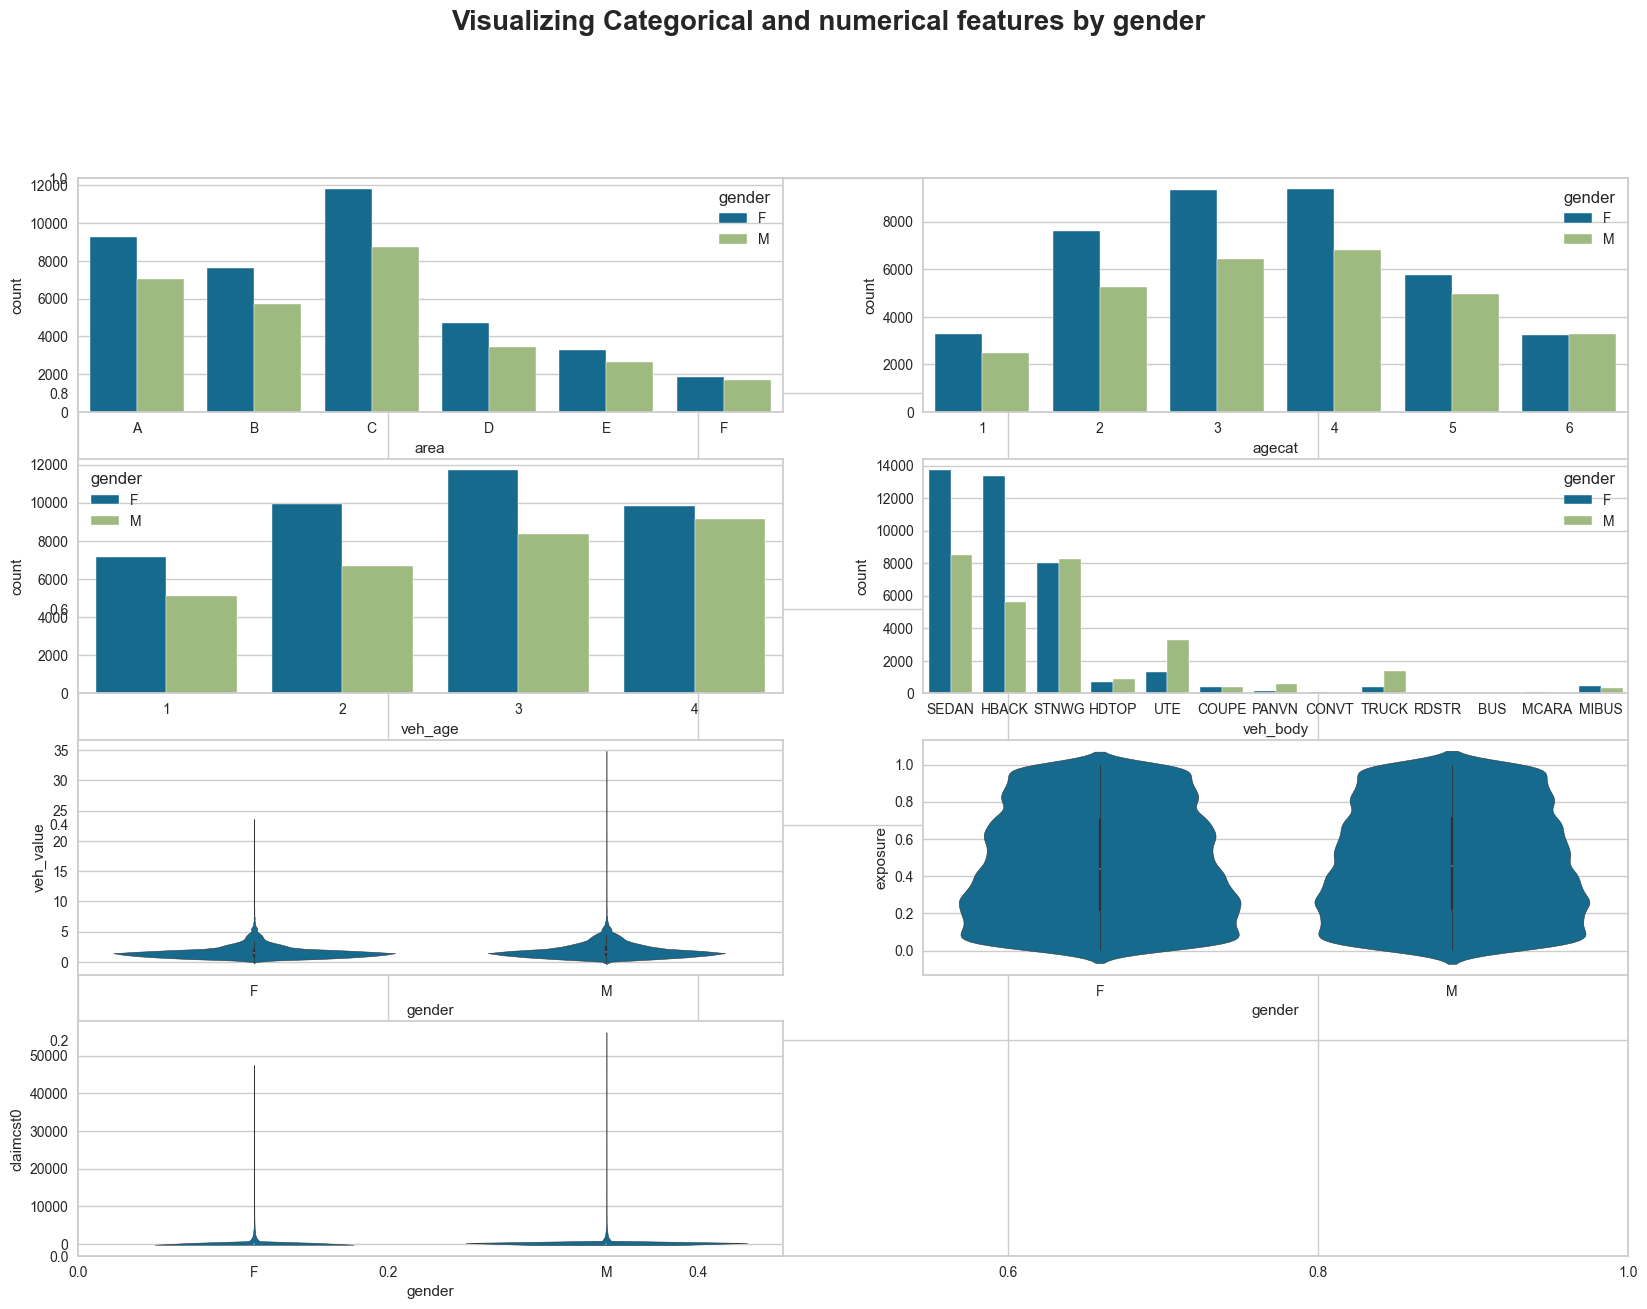

In [30]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by gender",fontsize=20,fontweight="bold",y=1.)
plt.subplot(421)
sns.countplot(x="area",hue="gender",data=df)
plt.subplot(422)
sns.countplot(x="agecat",hue="gender",data=df)
plt.subplot(423)
sns.countplot(x="veh_age",hue="gender",data=df)
plt.subplot(424)
sns.countplot(x="veh_body",hue="gender",data=df)
plt.subplot(425)
sns.violinplot(x="gender",y="veh_value",data=df)
plt.subplot(426)
sns.violinplot(x="gender",y="exposure",data=df)
plt.subplot(427)
sns.violinplot(x="gender",y="claimcst0",data=df)
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_gender.png',dpi=500);


---

In [35]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [36]:
x=df.drop("gender",axis=1)
y=df["gender"]

---

*Countinuous features Skewbess -outliers-*

In [37]:
x[countinuous_feature].skew(axis=0,skipna=True)

veh_value     2.968022
exposure      0.175557
claimcst0    17.502503
dtype: float64

---

*Transforming countinuous features to handle the outliers*

In [38]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value', 'claimcst0']
x_copy=pt.fit_transform(x[transform_features])

In [39]:
x_copy=pd.DataFrame(x_copy,columns=transform_features)
x_copy

,veh_value,claimcst0
0,0.103702,-0.270421
1,-0.043000,-0.270421
2,0.048639,-0.270421
3,0.081874,-0.270421
4,-0.102624,-0.270421
...,...,...
67851,-0.446192,-0.270421
67852,0.229457,-0.270421
67853,-2.565485,-0.270421
67854,-0.877562,-0.270421


In [40]:
x_copy.skew(axis=0,skipna=True)

veh_value    0.010369
claimcst0    3.427592
dtype: float64

---

*Visualizing  countinuous features after tranformation  :*

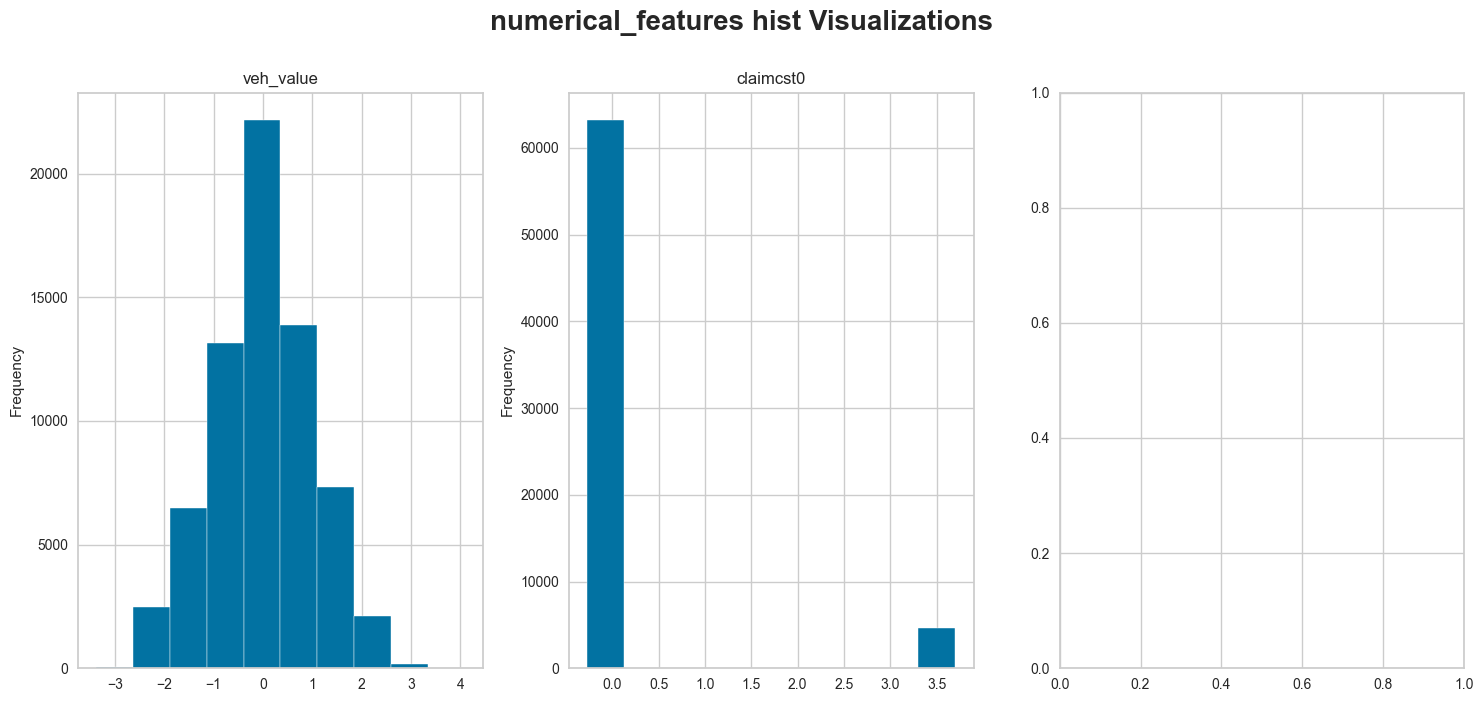

In [41]:
plot_numerical_features(x_copy[["veh_value","claimcst0"]],"hist")

---

In [42]:
for feature in categorical_features:
    print(feature,":",df[feature].unique())

veh_body : [ 9  3 10  4 12  2  7  1 11  8  0  5  6]
veh_age : [0 1 2 3]
gender : [0 1]
area : [0 1 2 3 4 5]
agecat : [0 1 2 3 4 5]


In [43]:
for feature in categorical_features:
    print(feature,":",df[feature].nunique())

veh_body : 13
veh_age : 4
gender : 2
area : 6
agecat : 6


---

*Apply ColumnTransformer to do all transdormation in once :*

In [47]:
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [48]:
sc=StandardScaler()
onencood=OneHotEncoder()
ordinalencod=OrdinalEncoder()
transform_pipe=Pipeline(steps=[
    ("transformer",PowerTransformer(method="yeo-johnson"))
    ])

In [49]:
transform_features=['veh_value','claimcst0']
transform_features

['veh_value', 'claimcst0']

In [50]:
list_num_features=list(numerical_features.columns)
list_num_features

['veh_value', 'exposure', 'claimcst0']

In [51]:
preprocessor=ColumnTransformer([
    #("OneHotEncoder",onencood,on_columns),
    #("Ordinal_Encoder",ordinalencod,ordered_columns),
    ("transformer",transform_pipe,transform_features),
    ("StandardScaler",sc,list_num_features)
]
)

In [52]:
x=preprocessor.fit_transform(x)

---

*Hundling unbalanced data :*

In [53]:
from imblearn.combine import SMOTETomek,SMOTEENN
smt=SMOTEENN(random_state=42,sampling_strategy="minority")
x_re,y_res=smt.fit_resample(x,y)


---

*Split data into train and test subdata :*

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x_re,y_res ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (14798, 5) and Y = (14798,) : 
Test data shape of X = (3700, 5) and Y = (3700,) : 


---

*Define models :*

In [55]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "LogisticRegression":LogisticRegression(),
        "SVC":SVC(),
        "KNeighborsClassifier":KNeighborsClassifier()
        
}

---

*Define evaluation funtion :*

In [56]:
def evaluation_preds_list(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    precision=precision_score(y_true,predicted)
    recall=recall_score(y_true,predicted)
    f1=f1_score(y_true,predicted)
    roc_auc=roc_auc_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
        "precision": round(precision,3),
        "recall":round(recall,3),
        "f1":round(f1,3),
        "roc_auc":round(roc_auc,3)

    }
   
    return metrics_dict

In [57]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    precision=precision_score(y_true,predicted)
    recall=recall_score(y_true,predicted)
    f1=f1_score(y_true,predicted)
    roc_auc=roc_auc_score(y_true,predicted)   
    return accuracy,precision,recall,f1,roc_auc

---

*Create one function to model the data :*

In [58]:
def evalua_models(x,y,models):
    x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20,random_state=42)
    models_list=[]
    accuracy_list=[]
    auc_list=[]
    pres_list=[]
    recall_list=[]
    fi_list=[]
    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_accuracy,test_predicted_precision,test_predicted_recall,\
        test_predicted_f1,test_predicted_roc_auc=evaluation_preds(y_test,test_predicted)
       
        accuracy_list.append(test_predicted_accuracy)
        pres_list.append(test_predicted_precision)
        recall_list.append(test_predicted_recall)
        fi_list.append(test_predicted_f1)
        auc_list.append(test_predicted_roc_auc)

        print(list(models.keys())[i])
        
        models_list.append(list(models.keys())[i])
        
        print( test_predicted_accuracy)
        print( test_predicted_precision)
        print( test_predicted_recall)
        print( test_predicted_f1)
        print( test_predicted_roc_auc)
        print("===========================")

    report=pd.DataFrame(list(zip(models_list,accuracy_list,pres_list,recall_list,fi_list,auc_list)),columns=["model","acc","precision","recall","f1","auc"]).sort_values(by="acc",ascending=False) 
    return report
  

---

*Apply Data Modeling*

In [59]:
evalua_models(x_re,y_res,models)

XGBRFClassifier
0.6697297297297298
0.75
0.5482866043613707
0.6334733053389322
0.6749324791818128
GradientBoostingClassifier
0.6675675675675675
0.7310756972111554
0.5716510903426791
0.6416083916083916
0.6716767289368413
RandomForestClassifier
0.89
0.8912931478619268
0.8982346832814122
0.8947504525471942
0.8896472176271774
AdaBoostClassifier
0.652972972972973
0.7473035439137135
0.5036344755970924
0.6017369727047146
0.6593707890950512
DecisionTreeClassifier
0.8837837837837837
0.8855670103092783
0.8920041536863966
0.8887739265390585
0.8834316146109548
LogisticRegression
0.6459459459459459
0.7196861626248217
0.5238836967808931
0.6063701923076923
0.6511752193036371
SVC
0.6467567567567568
0.7231434751261716
0.5207684319833853
0.6054935104135225
0.6521542272656499
KNeighborsClassifier
0.81
0.8089944416371905
0.8312564901349948
0.8199743918053777
0.8090893499152991


,model,acc,precision,recall,f1,auc
2,RandomForestClassifier,0.890000,0.891293,0.898235,0.894750,0.889647
4,DecisionTreeClassifier,0.883784,0.885567,0.892004,0.888774,0.883432
7,KNeighborsClassifier,0.810000,0.808994,0.831256,0.819974,0.809089
0,XGBRFClassifier,0.669730,0.750000,0.548287,0.633473,0.674932
1,GradientBoostingClassifier,0.667568,0.731076,0.571651,0.641608,0.671677
3,AdaBoostClassifier,0.652973,0.747304,0.503634,0.601737,0.659371
6,SVC,0.646757,0.723143,0.520768,0.605494,0.652154
5,LogisticRegression,0.645946,0.719686,0.523884,0.606370,0.651175


---

*Apply RandomForestClassifier :*

In [60]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

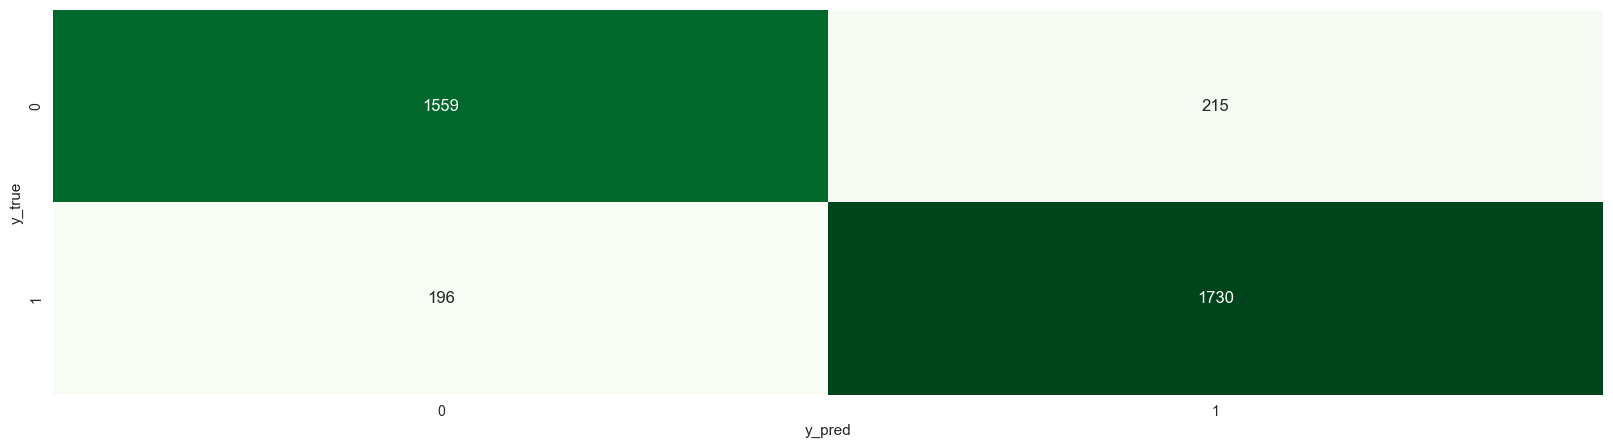

In [61]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Greens", fmt = ".0f",cbar=False)
plt.xlabel("y_pred")
plt.ylabel("y_true");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/gender_confusion_matrixPlot.png',dpi=500);

In [62]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1774
           1       0.89      0.90      0.89      1926

    accuracy                           0.89      3700
   macro avg       0.89      0.89      0.89      3700
weighted avg       0.89      0.89      0.89      3700



---

*ROC curve :*

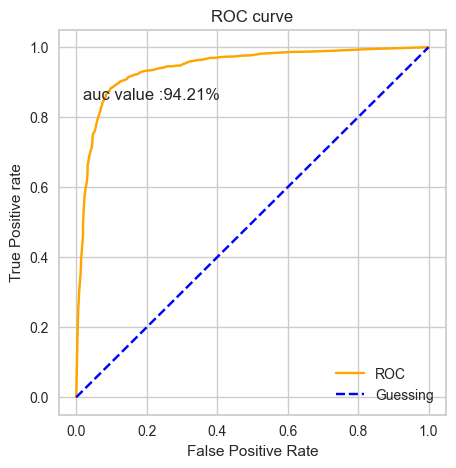

In [63]:
fpr,tpr,thresh=roc_curve(y_test,clf.predict_proba(x_test)[:,1])
AucValue=roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])
AucValue=f"{AucValue*100:.2f}%"
def plot_roc_curve(fpr,tpr):
    matplotlib.rcParams["figure.figsize"]=(5,5)
    plt.plot(fpr,tpr,color="orange",label="ROC")
    plt.plot([0,1],[0,1],color="blue",linestyle="--",label="Guessing")
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.text(0.02,0.85, f'auc value :{AucValue}')
    plt.legend()

plot_roc_curve(fpr,tpr);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/ROCcurveGraphs/gender_ROCcurveGraphs.png',dpi=500);    

In [66]:
clf.feature_importances_.sum()

np.float64(1.0)

In [64]:
clf.feature_names_in=list(df.drop("gender",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.220959
1,exposure,0.014676
2,claimcst0,0.220967
3,veh_body,0.523576
4,veh_age,0.019822
5,area,NaN
6,agecat,NaN


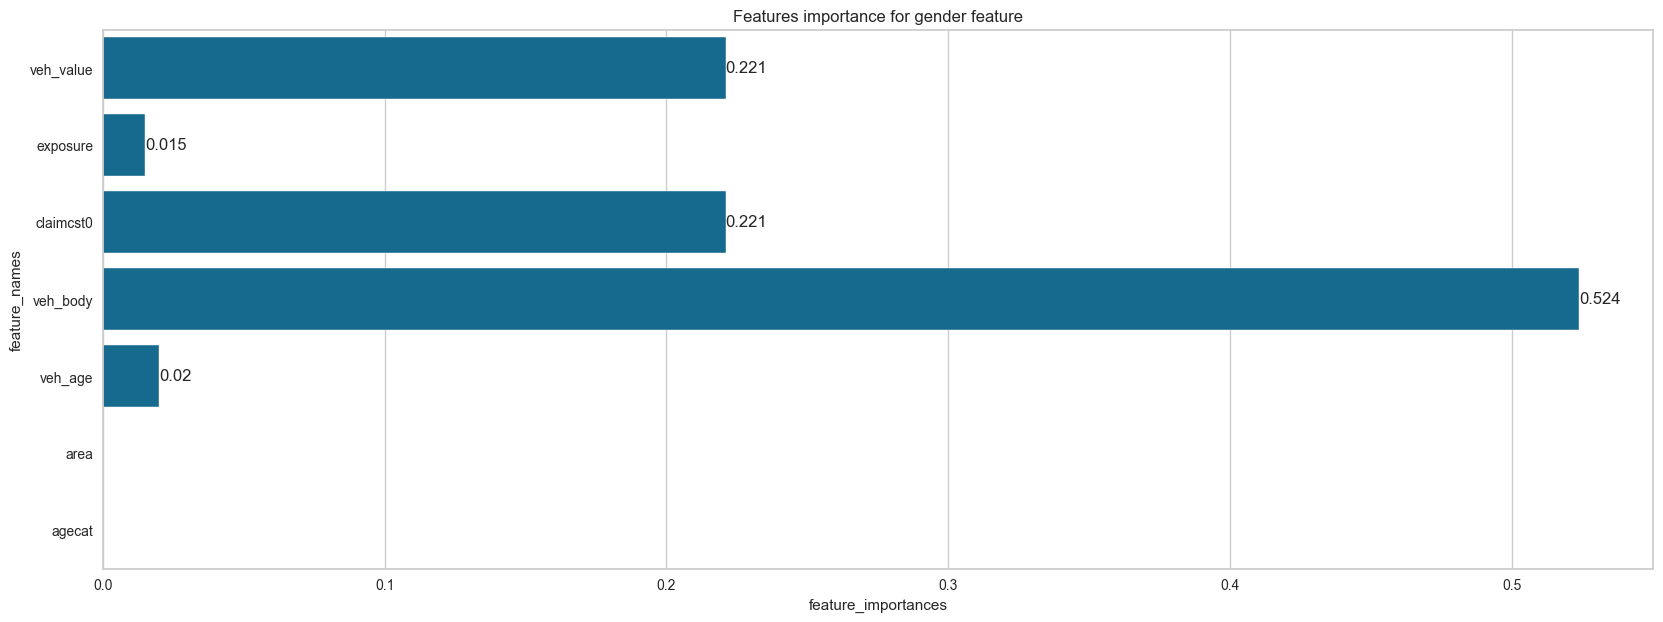

In [67]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for gender feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/gender_featureImportanc.png',dpi=500);

*Saving Best model :*

In [68]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/gender_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---